In [1]:
import numpy as np

from utils_kernel import cosine_kernel
from utils_visualization import plot_kernel


# EXAMPLE DATA MANIFOLDS AND KERNELS

In [2]:
p = 3
cov_matrix = np.identity(p)*0.5

norm_data = np.matmul(np.random.randn(1000, p), cov_matrix)

mix_data1 = np.matmul(np.random.randn(500, p), cov_matrix) - 4
mix_data2 = np.matmul(np.random.randn(500, p), cov_matrix) + 4

mix_data = np.concatenate([mix_data1, mix_data2])

norm_data_kernel = cosine_kernel(norm_data)
mix_data_kernel = cosine_kernel(mix_data)

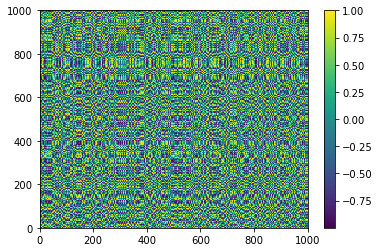

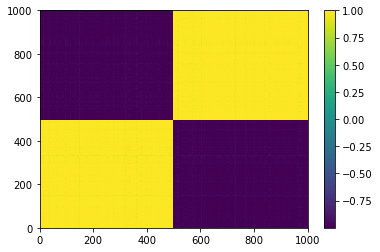

In [3]:
plot_kernel(norm_data_kernel)
plot_kernel(mix_data_kernel)

# MANIFOLDS AND GEODESICS

In [4]:
import time as time
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import mpl_toolkits.mplot3d.axes3d as p3
from sklearn.cluster import AgglomerativeClustering
from sklearn.datasets.samples_generator import make_swiss_roll
from sklearn.metrics.pairwise import euclidean_distances

from sklearn.manifold import TSNE
from sklearn.manifold import Isomap
from dijsktra import shortestPath

from utils_kernel import euclidean_tv_kernel
from utils_kernel import normalize_soften_kernel


In [5]:
# SWISS ROLL
def generate_geodesic(n_points):
    #t = np.linspace(3.1*np.pi, 4.4*np.pi, n_points)
    #t = np.linspace(1.5*np.pi, 4.4*np.pi, n_points)
    t = np.linspace(2.5*np.pi, 3.4*np.pi, n_points)
    x = t * np.cos(t)
    y = 10 * np.ones(len(t))
    #y = (10.0/14.0) * t
    z = t * np.sin(t)
    X = np.column_stack((x, y, z))
    X_init = X[0,:]
    X_end = X[len(t)-1,:]
    return X, X_init, X_end

def make_manifold_data(n_samples=500):
    X, t = make_swiss_roll(n_samples=n_samples-2, noise=0.2, random_state=42)
    
    geodesic, geodesic_init, geodesic_end = generate_geodesic(20)
    X = np.concatenate([X, np.array([geodesic_init, geodesic_end])])
    
    #embed = TSNE(n_components=2, random_state=42)
    embed = Isomap(n_components=2)
    X_embed = embed.fit_transform(np.concatenate([X, geodesic]))
    
    return X, t, geodesic, geodesic_init, geodesic_end, X_embed
    
X, t, geodesic, geodesic_init, geodesic_end, X_embed = make_manifold_data(610)


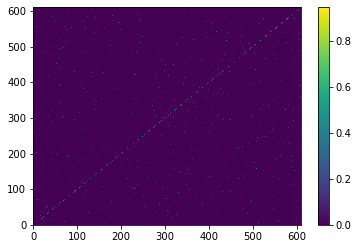

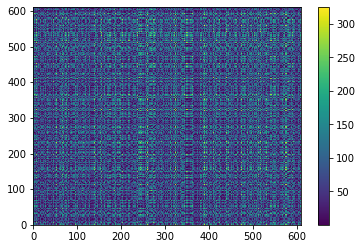

In [6]:
def generate_dijsktra_trajectory(X):
    swiss_roll_kernel = euclidean_tv_kernel(X)
    swiss_roll_soft_kernel = normalize_soften_kernel(swiss_roll_kernel, temp=0.025)
    plot_kernel(swiss_roll_soft_kernel)
    swiss_roll_weight_matrix = -np.log(swiss_roll_soft_kernel)
    plot_kernel(swiss_roll_weight_matrix)
    dijsktra_trajectory_ids = shortestPath(G=swiss_roll_weight_matrix, start=len(X)-1, end=len(X)-2)
    return dijsktra_trajectory_ids

dijsktra_trajectory_ids = generate_dijsktra_trajectory(X)

No handles with labels found to put in legend.


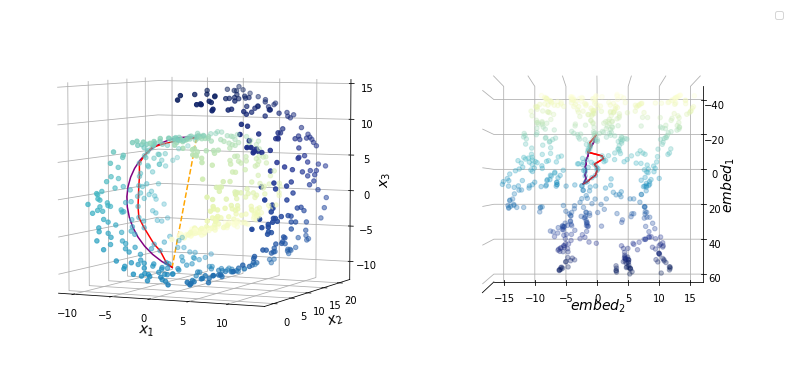

In [7]:
def plot_swiss_roll(X, geodesic, geodesic_init, geodesic_end, X_embed):
    fig = plt.figure(figsize=(14, 7))
    #plt.figaspect(.4)
    fig.subplots_adjust(top=0.85)
    plt.subplots_adjust(wspace=0)
    
    # Swiss roll with geodesic
    axes = [-11.5, 14, -2, 23, -12, 15]
    ax1 = fig.add_subplot(121, projection='3d')
    #ax1.title.set_text('Swiss Roll with Geodesic Path')
    ax1.scatter(X[:-2, 0], X[:-2, 1], X[:-2, 2], c=t, cmap=plt.cm.YlGnBu)
    
    ax1.plot(X[-2:, 0], X[-2:, 1], X[-2:, 2], color='orange', linestyle='--')
    ax1.plot(geodesic[:, 0], geodesic[:, 1], geodesic[:, 2],
             color='purple', linestyle='-', linewidth=1.5)
    
    ax1.plot(X[dijsktra_trajectory_ids, 0], X[dijsktra_trajectory_ids, 1], X[dijsktra_trajectory_ids, 2],
             color='red', linestyle='-', linewidth=1.5)
    
    ax1.view_init(5, -65)
    ax1.set_xlabel("$x_1$", fontsize=14)
    ax1.set_ylabel("$x_2$", fontsize=14)
    ax1.set_zlabel("$x_3$", fontsize=14)
    ax1.set_xlim(axes[0:2])
    ax1.set_ylim(axes[2:4])
    ax1.set_zlim(axes[4:6]) 

    #3D Grid color white
    ax1.w_xaxis.pane.set_color('w')
    ax1.w_yaxis.pane.set_color('w')
    ax1.w_zaxis.pane.set_color('w')
    #ax1.w_xaxis.pane.set_color('w')
    #ax1.w_yaxis.pane.set_color('w')
    #ax1.w_zaxis.pane.set_color('w')
    
    # Embedding with geodesic
    ax2 = fig.add_subplot(122, projection='3d')
    ax2.view_init(90, 0)
    ax2.w_xaxis.pane.set_color('w')
    ax2.w_yaxis.pane.set_color('w')
    ax2.w_zaxis.pane.set_color('w')
    #ax2.title.set_text('Embeddings with Geodesic Path')
    ax2.set_zticks([])
    ax2.set_xlabel("$embed_1$", fontsize=14)
    ax2.set_ylabel("$embed_2$", fontsize=14)
    
    # Plot Embeddings
    ax2.plot(X_embed[-20:,0], X_embed[-20:,1],
             color='purple', linestyle='-', linewidth=1.5)
    ax2.plot(X_embed[dijsktra_trajectory_ids, 0],
             X_embed[dijsktra_trajectory_ids, 1],
             color='red', linestyle='-', linewidth=1.5)
    ax2.plot(X_embed[-20:,0], X_embed[-20:,1],
             color='purple', linestyle='-', linewidth=1.5)
    ax2.plot(X_embed[dijsktra_trajectory_ids, 0],
             X_embed[dijsktra_trajectory_ids, 1],
             color='red', linestyle='-', linewidth=1.5)
    ax2.scatter(X_embed[:-22,0], X_embed[:-22,1], c=t, cmap=plt.cm.YlGnBu, alpha=0.3)
    plt.grid(True)
    
    plt.legend()
    plt.show()

plot_swiss_roll(X, geodesic, geodesic_init, geodesic_end, X_embed)